[6.26654296e-01 3.36323198e-01 2.28707844e-02 1.38505917e-02
 2.85251172e-04]
Gaussian Process Train R^2 0.999916915421516
Gaussian Process Valid R^2 0.9998446986396333
Training set loss: 0.0009100419370825539
Testing Set Loss 0.0016557091811551104
Gaussian Proccess Training Field Reconstruction Loss: 1.5415614613159247e-06
Gaussian Proccess Validation Field Reconstruction Loss: 2.407477252493996e-06
PCA Training Field Reconstruction Loss 4.911898811190669e-07
PCA Validation Field Reconstruction Loss 4.964555752605031e-07


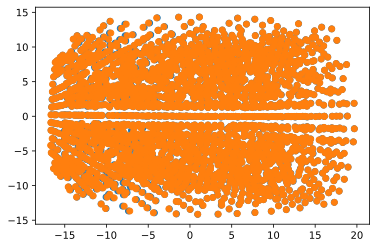

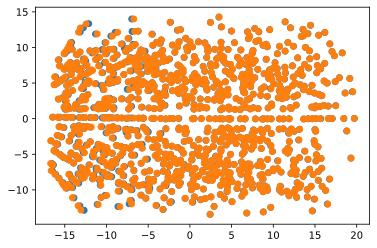

In [2]:
## Make Training Validation Set Split

from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from ssapp import Utils
from torch.utils.data.dataloader import DataLoader
from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset,PatchAntennaDataset2, set_global_random_seed,load_serialized_dataset, dataset_is_serialized
from ssapp.data.Metrics import relRMSE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
import numpy as np




%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

set_global_random_seed()

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

dataset_name = 'PatchAntennaDataset2'
# Choose Dataset
if dataset_is_serialized(dataset_name):
    dataset = load_serialized_dataset(dataset_name)
else:
    dataset = PatchAntennaDataset2() # Large Dataset 
    #dataset = PatchAntennaDataset1() # Small Dataset

train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)


train_loader = DataLoader(train_data,batch_size=len(train_data),shuffle=True)
test_loader = DataLoader(test_data,batch_size=len(test_data),shuffle=True)

TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(test_loader))


pca = PCA(n_components=5)
pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
print(pca.explained_variance_ratio_)
pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))


PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)


gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 
print('Gaussian Process Train R^2',gpr.score(TRAIN_PARAMS, pca_train))
print('Gaussian Process Valid R^2',gpr.score(TEST_PARAMS, pca_val))

TRAIN_LOSS = metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train)
TEST_LOSS = metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val)

print('Training set loss:', TRAIN_LOSS)
print('Testing Set Loss', TEST_LOSS)


PCA_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten())
PCA_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten())


## Loss in reconstruction
GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

GPR_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten())
GPR_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten())




print('Gaussian Proccess Training Field Reconstruction Loss:',GPR_TRAIN_RECONSTRUCTION_LOSS)
print('Gaussian Proccess Validation Field Reconstruction Loss:',GPR_TEST_RECONSTRUCTION_LOSS)
print('PCA Training Field Reconstruction Loss',PCA_TRAIN_RECONSTRUCTION_LOSS)
print('PCA Validation Field Reconstruction Loss',PCA_TEST_RECONSTRUCTION_LOSS)


# Show Training Latent Space

plt.figure()
plt.scatter(pca_train[:,0],pca_train[:,1])
plt.scatter(gpr.predict(TRAIN_PARAMS)[:,0],gpr.predict(TRAIN_PARAMS)[:,1])

# Show Validation Latent Space

plt.figure()
plt.scatter(pca_val[:,0],pca_val[:,1])
plt.scatter(gpr.predict(TEST_PARAMS)[:,0],gpr.predict(TEST_PARAMS)[:,1])


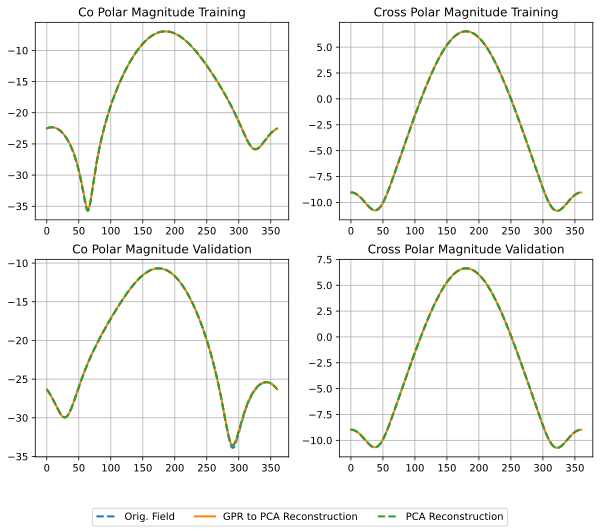

In [3]:
def mag_field(field,sample = 0,phi_cut = 0):
    co_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,0]**2+field[sample,:,phi_cut,1]**2))
    cross_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,2]**2+field[sample,:,phi_cut,3]**2))

    return co_polar, cross_polar

TRAIN_SAMPLE = 20
TEST_SAMPLE = 300
# 
# Plot Training Field Reconstruction
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

axs[0,0].set_title('Co Polar Magnitude Training')
org_co_polar, org_cross_polar = mag_field(TRAIN_FIELDS,sample = TRAIN_SAMPLE)
gpr_co_polar, gpr_cross_polar = mag_field(GPR_TRAIN_RECONSTRUCTED_FIELD,sample = TRAIN_SAMPLE)
pca_co_polar, pca_cross_polar = mag_field(PCA_TRAIN_RECONSTRUCTED_FIELD,sample = TRAIN_SAMPLE)

axs[0,0].plot(org_co_polar, label = 'Orig. Field',linestyle =  '--')
axs[0,0].plot(gpr_co_polar,label = 'GPR to PCA Reconstruction')
axs[0,0].plot(pca_co_polar,label = 'PCA Reconstruction',linestyle =  '--')
fig.legend( loc = 'lower center',ncol = 3)

axs[0,1].set_title('Cross Polar Magnitude Training')
axs[0,1].plot(org_cross_polar, label = 'Orig. Field',linestyle =  '--')
axs[0,1].plot(gpr_cross_polar,label = 'GPR to PCA Reconstruction')
axs[0,1].plot(pca_cross_polar,label = 'PCA Reconstruction',linestyle =  '--')

# Plot Validation Field Reconstruction

org_co_polar, org_cross_polar = mag_field(TEST_FIELDS,sample = TEST_SAMPLE)
gpr_co_polar, gpr_cross_polar = mag_field(GPR_TEST_RECONSTRUCTED_FIELD,sample = TEST_SAMPLE)
pca_co_polar, pca_cross_polar = mag_field(PCA_TEST_RECONSTRUCTED_FIELD,sample = TEST_SAMPLE)

axs[1,0].set_title('Co Polar Magnitude Validation')
axs[1,0].plot(org_co_polar, label = 'Orig. Field',linestyle =  '--')
axs[1,0].plot(gpr_co_polar,label = 'GPR to PCA Reconstruction')
axs[1,0].plot(pca_co_polar,label = 'PCA Reconstruction',linestyle =  '--')

axs[1,1].set_title('Cross Polar Magnitude Validation')
axs[1,1].plot(org_cross_polar, label = 'Orig. Field',linestyle =  '--')
axs[1,1].plot(gpr_cross_polar,label = 'GPR to PCA Reconstruction')
axs[1,1].plot(pca_cross_polar,label = 'PCA Reconstruction',linestyle =  '--')
for ax in axs.flatten():
    ax.grid(True)


# Test Point From Simon

4332 1444
0.001558066221516587
0.002802288372662937
0.003059069972101468


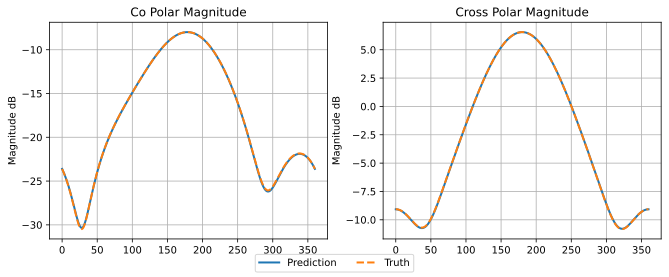

In [4]:
def mag_field(field,sample = 0,phi_cut = 0):
    co_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,0]**2+field[sample,:,phi_cut,1]**2))
    cross_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,2]**2+field[sample,:,phi_cut,3]**2))

    return co_polar, cross_polar


loaded_field_cut = np.genfromtxt('intrapolation_single_cut.cut', skip_header=2, max_rows = 361,dtype = np.float32).reshape(1,361,1,4)


truth_co_polar, truth_cross_polar =  mag_field(loaded_field_cut,phi_cut = 0)

## Make gpr Prediction
Test_Param_Point = np.array([[-1.5,8.5,3.04]]) #Point Chosen By Simon
Test_field = pca.inverse_transform(gpr.predict(Test_Param_Point)).reshape(1,361,3,4)
pred_co_polar, pred_cross_polar = mag_field(Test_field,phi_cut = 0)


# Plot 
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))
axs[0].set_title('Co Polar Magnitude')
axs[0].plot(pred_co_polar, label = 'Prediction')
axs[0].plot(truth_co_polar,label  = 'Truth',linestyle = '--')
axs[0].set_ylabel('Magnitude dB')
fig.legend(loc = 'lower center',ncol = 3)

axs[1].set_title('Cross Polar Magnitude')
axs[1].plot(pred_cross_polar, label = 'Prediction')
axs[1].plot(truth_cross_polar,label  = 'Truth',linestyle = '--')
axs[1].set_ylabel('Magnitude dB')

for ax in axs.flatten():
    ax.grid(True)


print(len(Test_field.flatten()),len(loaded_field_cut.flatten()))


print(relRMSE(Test_field[0,:,0,:].flatten(),loaded_field_cut[0,:,0,:].flatten()))

print(relRMSE(truth_co_polar.flatten(),pred_co_polar.flatten()))
print(relRMSE(truth_cross_polar.flatten(),pred_cross_polar.flatten()))

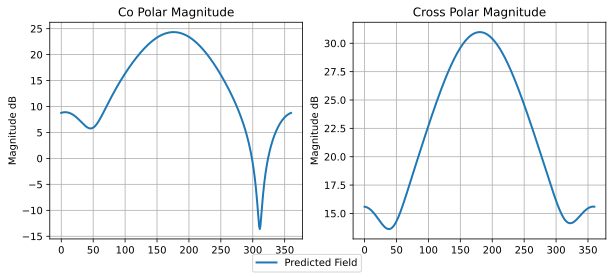

In [5]:

# Plot Training Field Reconstruction
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))


## Make gpr Prediction
Test_Param_Point = np.array([[2.3,4.0,2.85]])
Test_field = pca.inverse_transform(gpr.predict(Test_Param_Point)).reshape(1,361,3,4)




co_polar, cross_polar = mag_field(Test_field,phi_cut = 0)


axs[0].set_title('Co Polar Magnitude')
axs[0].plot(co_polar, label = 'Predicted Field')
axs[0].set_ylabel('Magnitude dB')
fig.legend( loc = 'lower center',ncol = 3)

axs[1].set_title('Cross Polar Magnitude')
axs[1].plot(cross_polar, label =  'Predicted Field')
axs[1].set_ylabel('Magnitude dB')

for ax in axs.flatten():
    ax.grid(True)

In [6]:
## Gaussian Process Loss as functino of PCA Components

HIGH_NUM_PCA = 20

Number_PCAs = []

sweep_info = {
        'PCR Train Rec. Loss': [],
        'PCR Validation Rec. Loss': [],
        'GP Train Latent Loss': [],
        'GP Validation Latent Loss': [],
        'GP-PCA Train Rec. Loss': [],
        'GP-PCA Validation Rec. Loss': [],
        'LR-PCA Train Rec. Loss': [],
        'LR-PCA Validation Rec. Loss': []
        
        }

for num_pca in range(1,HIGH_NUM_PCA+1):

    Number_PCAs.append(num_pca)
    pca = PCA(n_components=num_pca)
    pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
    pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))

    PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
    PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)

    gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 

    sweep_info['GP Train Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train))
    sweep_info['GP Validation Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val))

    sweep_info['PCR Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['PCR Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten()))

    ## Loss in reconstruction
    GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    LR = LinearRegression().fit(TRAIN_PARAMS, pca_train) 

    LR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    LR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    sweep_info['GP-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['GP-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten()))

    sweep_info['LR-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), LR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['LR-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), LR_TEST_RECONSTRUCTED_FIELD.flatten()))




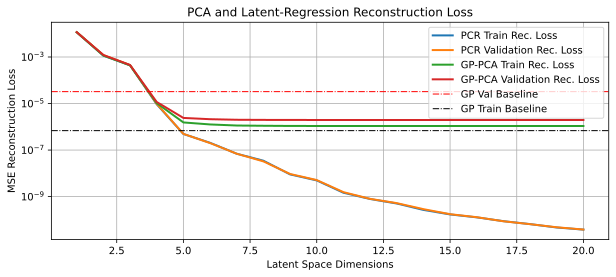

In [7]:
plt.figure(figsize = (10,4))
plt.semilogy(Number_PCAs,sweep_info['PCR Train Rec. Loss'],label ='PCR Train Rec. Loss' )
plt.semilogy(Number_PCAs,sweep_info['PCR Validation Rec. Loss'],label='PCR Validation Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Train Rec. Loss'],label = 'GP-PCA Train Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Validation Rec. Loss'],label = 'GP-PCA Validation Rec. Loss')
plt.axhline(3.2447262845002656e-05,color = 'red',linestyle = '-.',linewidth = 1,label = 'GP Val Baseline')
plt.axhline(6.84051583744767e-07,color = 'black',linestyle = '-.',linewidth = 1,label = 'GP Train Baseline')
plt.legend()
plt.xlabel('Latent Space Dimensions')
plt.ylabel('MSE Reconstruction Loss')
plt.title('PCA and Latent-Regression Reconstruction Loss')
plt.grid(True)

In [11]:
from ssapp.data.Metrics import relRMSE
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from ssapp.models.HelperFunctions import loadModel
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder


Number_PCAs = []

sweep_info = {
        'PCR Train Rec. Loss': [],
        'PCR Validation Rec. Loss': [],
        'GP Train Latent Loss': [],
        'GP Validation Latent Loss': [],
        'GP-PCA Train Rec. Loss': [],
        'GP-PCA Validation Rec. Loss': [],
        'LR-PCA Train Rec. Loss': [],
        'LR-PCA Validation Rec. Loss': [],
        '2D AE Train Rec. Loss': [],
        '2D AE Validation Rec. Loss' : [],
        'GP-AE Train Rec. Loss': [],
        'GP-AE Validation Rec. Loss': []
        }

for num_pca in range(1,HIGH_NUM_PCA+1):

    Number_PCAs.append(num_pca)
    pca = PCA(n_components=num_pca)
    pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
    pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))
    PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
    PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)


    #KERNEL = 1.0 * Matern(length_scale = 1,length_scale_bounds = (1e-30,1e5) )
    #KERNEL = ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed") # Defautlt kernel

    gpr = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())]).fit(TRAIN_PARAMS, pca_train)
    #gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train)



    sweep_info['GP Train Latent Loss'].append(relRMSE(gpr.predict(TRAIN_PARAMS), pca_train))
    sweep_info['GP Validation Latent Loss'].append(relRMSE(gpr.predict(TEST_PARAMS),pca_val))

    sweep_info['PCR Train Rec. Loss'].append(relRMSE(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['PCR Validation Rec. Loss'].append(relRMSE(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten()))

    ## Loss in reconstruction
    GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    LR = LinearRegression().fit(TRAIN_PARAMS, pca_train) 

    LR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    LR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    sweep_info['GP-PCA Train Rec. Loss'].append(relRMSE(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten()))

    sweep_info['GP-PCA Validation Rec. Loss'].append(relRMSE(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten()))

    sweep_info['LR-PCA Train Rec. Loss'].append(relRMSE(TRAIN_FIELDS.flatten(), LR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['LR-PCA Validation Rec. Loss'].append(relRMSE(TEST_FIELDS.flatten(), LR_TEST_RECONSTRUCTED_FIELD.flatten()))





The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


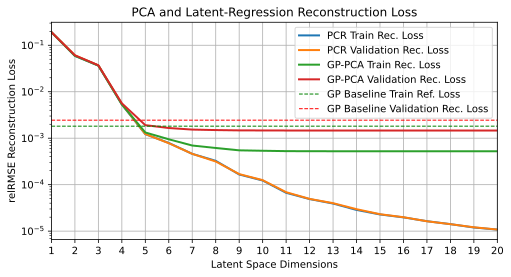

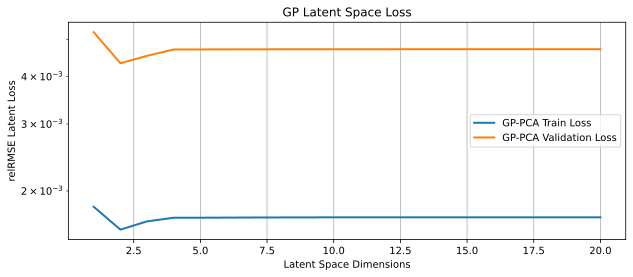

In [12]:
from ssapp.Utils import save_eps_figure, FigureSaver

figSaver = FigureSaver(subfolder = 'Patch Antenna Latent Space Regression')

plt.figure(figsize = (8,4))
plt.semilogy(Number_PCAs,sweep_info['PCR Train Rec. Loss'],label ='PCR Train Rec. Loss' )
plt.semilogy(Number_PCAs,sweep_info['PCR Validation Rec. Loss'],label='PCR Validation Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Train Rec. Loss'],label = 'GP-PCA Train Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Validation Rec. Loss'],label = 'GP-PCA Validation Rec. Loss')
plt.axhline(0.0018129177903997698,label = 'GP Baseline Train Ref. Loss',linestyle = '--',linewidth = 1,c = 'green')
plt.axhline(0.002442734103283217,label = 'GP Baseline Validation Rec. Loss',linestyle = '--',linewidth = 1,c = 'red')
plt.xlim(1,num_pca)
plt.xticks([x for x in range(1,HIGH_NUM_PCA+1)])
plt.legend()
plt.xlabel('Latent Space Dimensions')
plt.ylabel('relRMSE Reconstruction Loss')
plt.title('PCA and Latent-Regression Reconstruction Loss')
plt.grid(True)
figSaver.save('testFig')

plt.figure(figsize = (10,4))

plt.semilogy(Number_PCAs,sweep_info['GP Train Latent Loss'],label = 'GP-PCA Train Loss')
plt.semilogy(Number_PCAs,sweep_info['GP Validation Latent Loss'],label = 'GP-PCA Validation Loss')
plt.legend()
plt.xlabel('Latent Space Dimensions')
plt.ylabel('relRMSE Latent Loss')
plt.title('GP Latent Space Loss')
plt.grid(True)

In [ ]:
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
from ssapp.data.Metrics import relRMSEComplex
import pandas as pd 

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())])

benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'std_GP': Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())]),
                    'std_pca_GP': Pipeline([('scaler', StandardScaler()), ('PCA',PCA(n_components=5)), ('gp', GaussianProcessRegressor())]),
                    'Linear Reg.':LinearRegression(),
                    'Ridge Reg.': Ridge()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'MAPE':metrics.mean_absolute_percentage_error,
                'R Squared':metrics.r2_score,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score,
                'Relative RMSE': relRMSE,}


test_loss_dict = dict.fromkeys(test_metrics.keys(),[])

test_df = pd.DataFrame()

for name,model in benchmark_models.items():

    print(name)
    model.fit(TRAIN_PARAMS, TRAIN_FIELDS.reshape(len(TRAIN_FIELDS),-1))

    for test_name,test_metric in test_metrics.items():
        print(test_name)
        print('Train')
        print(test_metric(TRAIN_FIELDS.flatten(),model.predict(TRAIN_PARAMS).flatten()))
        print('Valid')
        print(test_metric(TEST_FIELDS.flatten(),model.predict(TEST_PARAMS).flatten()))


grp = GaussianProcessRegressor().fit(TRAIN_PARAMS, TRAIN_FIELDS.reshape(len(TRAIN_FIELDS),-1))
complex_error = relRMSEComplex(TEST_FIELDS, model.predict(TEST_PARAMS).reshape(TEST_FIELDS.shape))
print(complex_error)
print(np.abs(complex_error))
print(10*np.log10(1+np.abs(complex_error)))
print(np.angle(complex_error)*180/np.pi)

Gaus. Proc.
Mean Squared
Train
1.0810535740929526e-06
Valid
1.9621739163792652e-06
MAPE
Train
0.047638264669513555
Valid
0.04061027347352604
R Squared
Train
0.9999957977817525
Valid
0.9999923592330802
Max Error
Train
0.016363740571884944
Valid
0.022274046938129954
Explained Variance
Train
0.9999957977817525
Valid
0.9999923593771834
Relative RMSE
Train
0.0018129177903997698
Valid
0.002442734103283217
std_GP
Mean Squared
Train
8.989289446109777e-08
Valid
7.039115896501708e-07
MAPE
Train
0.017113996428410317
Valid
0.024743474362042172
R Squared
Train
0.9999996505727649
Valid
0.9999972589461394
Max Error
Train
0.004810605399085954
Valid
0.05321524497650987
Explained Variance
Train
0.9999996505727649
Valid
0.9999972598603464
Relative RMSE
Train
0.000522777008488622
Valid
0.0014631074546032628
std_pca_GP


ValueError: n_components=5 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'

In [27]:

from ssapp.Utils import genModelComparison
import pandas as pd
pd.options.display.float_format = '{:,.3e}'.format

benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'std_GP': Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())]),
                    'Linear Reg.':LinearRegression()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score,
                'Relative RMSE': relRMSE,}



df = genModelComparison(dataset, benchmark_models= benchmark_models, test_metrics=test_metrics, train_test_ratio=0.7)




,Gaus. Proc. Train,Gaus. Proc. Val,std_GP Train,std_GP Val,Linear Reg. Train,Linear Reg. Val
Mean Squared,0.000001,0.000002,9.467576e-08,9.502086e-07,0.001699,0.001733
MAPE,0.046079,0.042647,1.484475e-02,1.955705e-02,1.672755,0.940951
R Squared,0.999996,0.999993,9.999996e-01,9.999963e-01,0.993394,0.993253
Max Error,0.016279,0.026298,5.963880e-03,6.104652e-02,0.397255,0.391112
Explained Variance,0.999996,0.999993,9.999996e-01,9.999963e-01,0.993394,0.993253
Relative RMSE,0.001850,0.002369,5.365194e-04,1.699801e-03,0.072063,0.072841


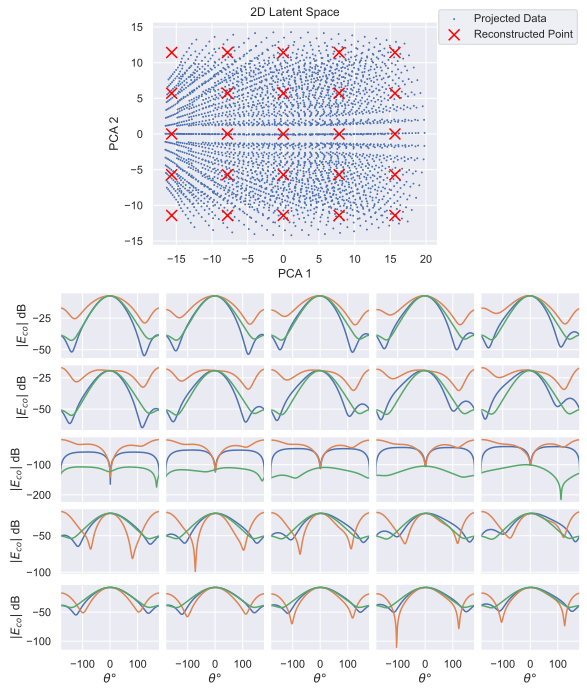

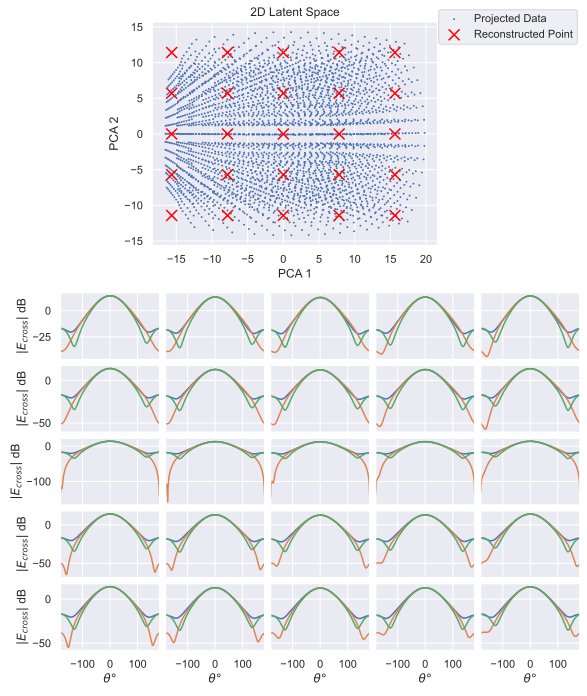

In [213]:
from ssapp.visualization.PCA_Visualisation import plotInverseTransformStandardPCA
from ssapp.Utils import FigureSaver

figsaver = FigureSaver()

transform = lambda a,b : np.sqrt(a**2+b**2)

plotInverseTransformStandardPCA(dataset,num_std_dev=1.7,
                                num_rows =5,
                                phi_cut =[0,1,2],
                                phi_labels = ['$\phi = 0$','$\phi = 45$','$\phi = 90$'],
                                component = 'co', 
                                num_cols = 5)

figsaver.save('Latent Space Rec Overview co',save_format= 'png')

plotInverseTransformStandardPCA(dataset,num_std_dev=1.7,
                                num_rows =5,
                                phi_cut =[0,1,2],
                                phi_labels = ['$\phi = 0$','$\phi = 45$','$\phi = 90$'],
                                component = 'cross', 
                                num_cols = 5)

figsaver.save('Latent Space Rec Overview cross',save_format= 'png')

